In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from data.data_fetcher import get_ohlcv
from indicators.technicals import compute_rsi, compute_ema, compute_macd, compute_atr, compute_sma
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

print("installed all dependencies...")

installed all dependencies...


In [35]:
# Get 4h BTC data
df = get_ohlcv("BTCUSDT", "4h", 2000)

# Add indicators
# Add features
df = compute_atr(df, period=14)
df = compute_rsi(df, period=14)
df = compute_sma(df, period=50)
df = compute_ema(df, period=50)
df = compute_macd(df)

df = df.dropna().reset_index(drop=True)

df.tail()

Fetching BTCUSDT from Binance...
 Binance fetch failed: HTTPSConnectionPool(host='api.binance.com', port=443): Max retries exceeded with url: /api/v3/klines?symbol=BTCUSDT&interval=4h&limit=2000 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001D39939B450>: Failed to resolve 'api.binance.com' ([Errno 11001] getaddrinfo failed)"))
Fetching from Yahoo Finance instead...


Price,timestamp,open,high,low,close,volume,prev_close,tr1,tr2,tr3,true_range,ATR,RSI,SMA_50,EMA_50,EMA_fast,EMA_slow,MACD,Signal
306,2025-09-03 04:00:00+00:00,111075.187500,111114.468750,110593.750000,111106.625000,1127833600,111066.804688,520.718750,47.664062,473.054688,520.718750,1254.565848,70.359790,110118.695625,110499.469643,110279.600785,109979.819566,299.781219,-23.443555
307,2025-09-03 08:00:00+00:00,111105.781250,111677.023438,110911.609375,111481.593750,1138827264,111106.625000,765.414062,570.398438,195.015625,765.414062,1240.572545,77.707089,110150.946875,110537.984313,110464.522780,110091.062099,373.460681,55.937292
308,2025-09-03 12:00:00+00:00,111477.343750,112500.179688,111091.890625,112241.468750,0,111481.593750,1408.289062,1018.585938,389.703125,1408.289062,1192.799107,74.280683,110189.851250,110604.787625,110737.899083,110250.351480,487.547603,142.259354
309,2025-09-03 16:00:00+00:00,112238.226562,112526.039062,111741.976562,112226.906250,910266368,112241.468750,784.062500,284.570312,499.492188,784.062500,1134.729911,81.866077,110237.597812,110668.400120,110966.977109,110396.762945,570.214164,227.850316
310,2025-09-03 20:00:00+00:00,112244.585938,112283.734375,111944.007812,111944.007812,8691380224,112226.906250,339.726562,56.828125,282.898438,339.726562,1096.173549,78.602938,110282.502969,110718.423951,111117.289525,110511.373676,605.915849,303.463423


In [36]:
df.shape

(311, 19)

In [37]:
df.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'prev_close',
       'tr1', 'tr2', 'tr3', 'true_range', 'ATR', 'RSI', 'SMA_50', 'EMA_50',
       'EMA_fast', 'EMA_slow', 'MACD', 'Signal'],
      dtype='object', name='Price')

In [38]:
SEQ_LEN = 30
features = ["close", "RSI", "SMA_50", "EMA_50", "MACD", "Signal", "ATR"]

X = df[features].values
y = df["close"].values  # target is next close

# Scale features and target separately
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1,1)).flatten()

# Make sequences
def create_sequences(X, y, seq_len=SEQ_LEN):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])  # next value
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)

# Train/test split
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# Torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32).view(-1,1)


In [39]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   # last timestep
        out = self.fc(out)
        return out

In [40]:
model = LSTMRegressor(input_dim=X_train.shape[2])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 30
BATCH_SIZE = 64
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCHS):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")


Epoch 5, Loss: 0.161805
Epoch 10, Loss: 0.096102
Epoch 15, Loss: 0.131742
Epoch 20, Loss: 0.140057
Epoch 25, Loss: 0.087632
Epoch 30, Loss: 0.064574


RMSE: 3489.48


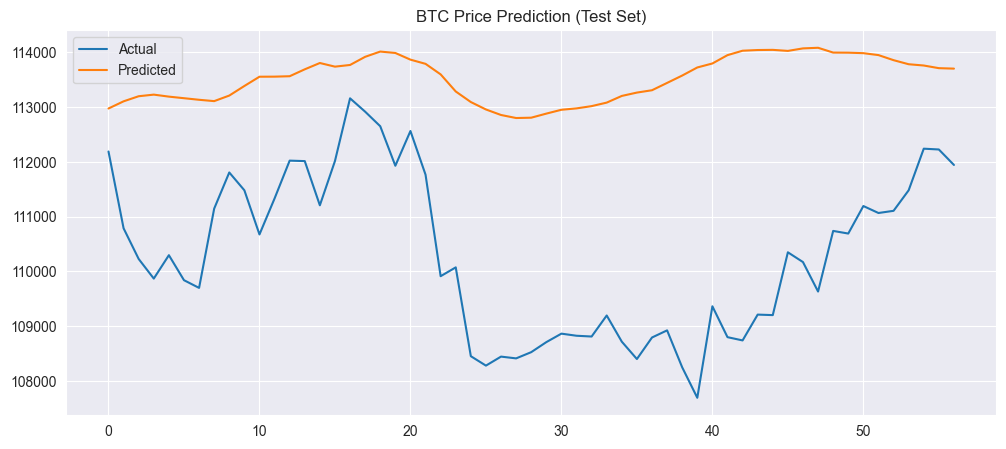

In [41]:
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_t).numpy().flatten()

# Inverse transform
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true = scaler_y.inverse_transform(y_test_t.numpy()).flatten()

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse:.2f}")

plt.figure(figsize=(12,5))
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("BTC Price Prediction (Test Set)")
plt.show()


In [42]:
torch.save(model.state_dict(), "models/lstm_regressor.pt")
import joblib
joblib.dump(scaler_X, "models/lstm_X_scaler.pkl")
joblib.dump(scaler_y, "models/lstm_y_scaler.pkl")

['models/lstm_y_scaler.pkl']